**Домашнее задание по теме «Использование pandas и numpy для очистки данных»**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

In [82]:
#загружаем данные
raw_df_train = pd.read_csv('rosbank_train.csv')
raw_df_test = pd.read_csv('rosbank_test.csv')
raw_df_train.head(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [83]:
raw_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


**Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test). Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения). При агрегации (pandas.DataFrame.groupby) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи**

In [4]:
print("Уникальных клиентов: ", len(raw_df_train.cl_id.unique()))

Уникальных клиентов:  5000


In [5]:
#выбираем из них 1000 клиентов для тестирования (случайно)
cl_ids_train = np.random.choice(raw_df_train.cl_id.unique(), size=1000, replace=False)
cl_ids_train_set = set(cl_ids_train)
len(cl_ids_train_set)

1000

In [6]:
#агреггируем по cl_id
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

**Обязательная часть: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи**

In [86]:
#найдем 10 самых популярных МСС
mcc_count = pd.DataFrame(raw_df_train['MCC'].value_counts())
mcc_count.reset_index(inplace=True)
mcc_count.columns = ['MCC', 'count']
mcc_count = mcc_count.head(10)
mcc_count

,MCC,count
0,5411,121640
1,6011,54382
2,5814,41351
3,5812,30027
4,5499,27237
5,5541,19816
6,5912,18728
7,5999,13073
8,6012,10056
9,5921,8578


Самый популярный MCC 5411 "Бакалейные магазины, супермаркеты", т.е. чаще всего люди расплачиваются в магазинах. На втором месте - 6011 "Операции с наличными в банкоматах" , а на третьем - 5814 "Фастфуд".

In [87]:
# Посмотрим активность клиентов по дням недели
# Преобразуем "TRDATETIME" в datetime
raw_df_train['TRDATETIME'] = pd.to_datetime(raw_df_train['TRDATETIME'], format='%d%b%y:%H:%M:%S')
# Создаем два столбца с номером дня недели "weekday" и с названием "weekday_name"
raw_df_train['weekday'] = pd.DatetimeIndex(raw_df_train['TRDATETIME']).weekday
raw_df_train['weekday_name'] = pd.DatetimeIndex(raw_df_train['TRDATETIME']).weekday_name

raw_df_train.head(10)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,weekday,weekday_name
0,01/10/2017,0,5200,NaN,810,2017-10-21 00:00:00,5023.0,POS,0,0.0,5,Saturday
1,01/10/2017,0,6011,NaN,810,2017-10-12 12:24:07,20000.0,DEPOSIT,0,0.0,3,Thursday
2,01/12/2017,0,5921,NaN,810,2017-12-05 00:00:00,767.0,POS,0,0.0,1,Tuesday
3,01/10/2017,0,5411,NaN,810,2017-10-21 00:00:00,2031.0,POS,0,0.0,5,Saturday
4,01/10/2017,0,6012,NaN,810,2017-10-24 13:14:24,36562.0,C2C_OUT,0,0.0,1,Tuesday
5,01/10/2017,1,5814,NaN,810,2017-10-16 00:00:00,380.0,POS,0,0.0,0,Monday
6,01/10/2017,1,5814,NaN,810,2017-10-10 00:00:00,378.0,POS,0,0.0,1,Tuesday
7,01/10/2017,1,5814,NaN,810,2017-10-16 00:00:00,199.0,POS,0,0.0,0,Monday
8,01/10/2017,1,5814,NaN,810,2017-10-11 00:00:00,400.0,POS,0,0.0,2,Wednesday
9,01/07/2017,1,5411,NaN,810,2017-07-26 00:00:00,598.0,POS,0,0.0,2,Wednesday


In [88]:
weekday_name_count = pd.DataFrame(raw_df_train['weekday'].value_counts())
weekday_name_count.reset_index(inplace=True)
weekday_name_count.columns = ['weekday', 'count']
weekday_name_count.sort_values('weekday')

,weekday,count
5,0,65927
4,1,68509
3,2,69485
2,3,71458
0,4,78993
1,5,74027
6,6,62114


Text(0, 0.5, 'Количество транзакций')

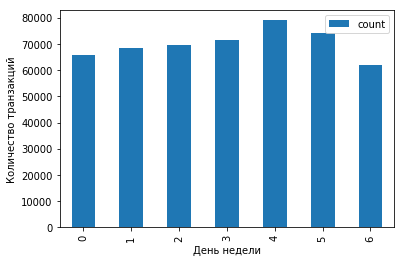

In [89]:
#строим для наглядности
weekday_name_count.sort_values('weekday').plot.bar('weekday')
plt.xlabel('День недели')
plt.ylabel('Количество транзакций')

Наибольшая активность клиентов в пятницу, а наименьшая - в воскресенье.

In [90]:
#найдем самые популярные категории транзакций (trx_category)
raw_df_train.groupby(['trx_category']).sum()['cl_id'].sort_values(ascending=False).head(10)

trx_category
POS               2004340266
DEPOSIT            132177447
WD_ATM_ROS          77801423
WD_ATM_PARTNER      41512587
C2C_IN              37376588
C2C_OUT             23621891
WD_ATM_OTHER        19930734
BACK_TRX            14250116
CAT                  4351516
CASH_ADV              143330
Name: cl_id, dtype: int64

Самая популярная категория - POS, т.е. оплата в точках продаж, на втором месте - операции с наличными через банкоматы.